In [ ]:
import os
import cv2
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
import matplotlib.pyplot as plt
import seaborn as sns


import requests

In [ ]:


import os

import hashlib

# List of image URLs
urls = [
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT6xOV3ceRNeJCYbb0o-jy26YIYArG4R8m4gQ&s',
    'https://images.firstpost.com/wp-content/uploads/2021/01/Mayabazar640-min.jpg?im=FitAndFill=(596,336)'
    # add the url of the images to test
]

# Folder path to save images
folder_path = r"C:\Users\dines\Desktop\sample_images"

# Create folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Loop through URLs to download images
for url in urls:
    # Create a unique filename based on the URL
    url_hash = hashlib.md5(url.encode()).hexdigest()
    image_path = os.path.join(folder_path, f"{url_hash}.jpg")

    # Download and save the image
    response = requests.get(url)
    if response.status_code == 200:
        with open(image_path, 'wb') as file:
            file.write(response.content)
        print(f"Image saved to {image_path}")
    else:
        print(f"Failed to retrieve the image from {url}")



Image saved to C:\Users\dines\Desktop\sample_images\6d0fd6851e694072fa71219920a30cbd.jpg


In [30]:
import os
from PIL import Image

def convert_images_to_bw(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)
        try:
            with Image.open(file_path) as img:
                bw_img = img.convert('L')
                bw_img.save(os.path.join(output_folder, filename))
                print(f"Converted {filename} to black and white.")
        except Exception as e:
            print(f"Could not process {filename}: {e}")


input_folder = r"C:\Users\dines\Desktop\sample_images"
output_folder = r'C:\Users\dines\Desktop\sample_gray' 

convert_images_to_bw(input_folder, output_folder)

Converted 6d0fd6851e694072fa71219920a30cbd.jpg to black and white.
Converted Bilateral_1.jpg to black and white.
Converted Bilateral_2.jpg to black and white.
Converted CLAHE_1.jpg to black and white.
Converted CLAHE_2.jpg to black and white.
Converted Guided_1.jpg to black and white.
Converted Guided_2.jpg to black and white.


In [31]:
def show_image(image):
    print("image colurized")
    # plt.imshow(cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()


def save_processed_image( processed, title, output_folder):
    processed_save_path = os.path.join(output_folder, f"{title}")
    cv2.imwrite(processed_save_path, processed)

    print(f"Processed image saved at: {processed_save_path}")



def show_images_side_by_side(original, processed, title):
    print(f"Original: {original.shape}, Processed: {processed.shape}")
 
    # plt.figure(figsize=(10, 5))

   
    # plt.subplot(1, 2, 1)
    # plt.imshow(original, cmap='gray')
    # plt.title(f"Original - {title}")
    # plt.axis('off')  

    
    # plt.subplot(1, 2, 2)
    # plt.imshow(processed, cmap='gray')
    # plt.title(f"Bilateral Filtered - {title}")
    # plt.axis('off')  

    
    # plt.show()

In [32]:
import os
import requests
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import applications
from keras.models import load_model

BATCH_SIZE = 1

def download_file(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)

def setup_model():
    if not os.path.exists("MODEL"):
        os.makedirs("MODEL")
    model_path = "MODEL/my_model_colorization.h5"
    model_url = "http://dev.ipol.im/~lraad/chromaGAN/model/my_model_colorization.h5"
    if not os.path.isfile(model_path):
        print("Downloading the model...")
        download_file(model_url, model_path)
    else:
        print("Model already exists.")

class DATA():
    def __init__(self, dirname):
        self.dir_path = dirname
        self.filelist = [f for f in os.listdir(self.dir_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.batch_size = BATCH_SIZE
        self.size = len(self.filelist)
        self.data_index = 0

    def read_img(self, filename):
        IMAGE_SIZE = 224
        MAX_SIDE = 1500
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Unable to read image: {filename}")
            return False, None, None, None, None
        height, width, _ = img.shape
        if height > MAX_SIDE or width > MAX_SIDE:
            r = min(MAX_SIDE / height, MAX_SIDE / width)
            img = cv2.resize(img, (math.floor(width * r), math.floor(height * r)))
            print(f"Resized image to {img.shape[:2]}")
        labimg = cv2.cvtColor(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)), cv2.COLOR_BGR2Lab)
        labimg_ori = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        return True, np.expand_dims(labimg[:, :, 0], axis=-1), labimg[:, :, 1:], img, np.expand_dims(labimg_ori[:, :, 0], axis=-1)

    def generate_batch(self):
        batch, labels, filelist, originalList, labimg_oritList = [], [], [], [], []
        for i in range(self.batch_size):
            filename = os.path.join(self.dir_path, self.filelist[self.data_index])
            ok, greyimg, colorimg, original, labimg_ori = self.read_img(filename)
            if ok:
                filelist.append(self.filelist[self.data_index])
                batch.append(greyimg)
                labels.append(colorimg)
                originalList.append(original)
                labimg_oritList.append(labimg_ori)
            self.data_index = (self.data_index + 1) % self.size
        return np.array(batch) / 255, np.array(labels) / 255, filelist, np.array(originalList), np.array(labimg_oritList) / 255

def deprocess(imgs):
    imgs = imgs * 255
    imgs = np.clip(imgs, 0, 255)
    return imgs.astype(np.uint8)

def reconstruct(batchX, predictedY):
    if batchX.shape[:2] != predictedY.shape[:2]:
        predictedY = cv2.resize(predictedY, (batchX.shape[1], batchX.shape[0]))
    result = np.concatenate((batchX, predictedY), axis=-1)
    return cv2.cvtColor(result, cv2.COLOR_Lab2BGR)



def sample_images(input_folder, output_folder):
    save_path = os.path.join("MODEL", "my_model_colorization.h5")
    colorizationModel = load_model(save_path)
    test_data = DATA(input_folder)

    if test_data.size == 0:
        raise ValueError("No images found in the input folder.")
    if BATCH_SIZE > test_data.size:
        raise ValueError("Batch size exceeds the number of images in the input folder.")

    total_batch = int(test_data.size / BATCH_SIZE)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for b in range(total_batch):
        batchX, batchY, filelist, original, labimg_oritList = test_data.generate_batch()
        if batchX.any():
            predY, _ = colorizationModel.predict(np.tile(batchX, [1, 1, 1, 3]))
            for i in range(BATCH_SIZE):
                predY_2 = deprocess(predY[i])
                predResult_2 = reconstruct(deprocess(labimg_oritList[i]), predY_2)
                save_path = os.path.join(output_folder, filelist[i])
                cv2.imwrite(save_path, predResult_2)
                print(f"Saved colorized image to {save_path}")



In [33]:

def process_and_show_images(input_folder, output_folder,filtered):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

   
    for image_name in os.listdir(input_folder):
        input_path = os.path.join(input_folder, image_name)

        
        if os.path.isfile(input_path) and image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            print(f"Processing {image_name}...")

            
            image = cv2.imread(input_path)

            if image is None:
                print(f"Failed to load {image_name}")
                continue
            filtered_image = filtered(image)

            
            save_processed_image( filtered_image, image_name, output_folder)

            
            show_images_side_by_side(image, filtered_image, image_name)


In [34]:
# flip all images in the dataset
def only_flip(image):
    flipped_image = cv2.flip(image, 1)

    
    return flipped_image

input_folder = r'C:\Users\dines\Desktop\sample_images' 
output_folder = r'C:\Users\dines\Desktop\sample_images_flip' 

process_and_show_images(input_folder, output_folder,only_flip)

def custom(image):
    flipped_image = cv2.flip(image, 1)
    gaussian_blur = cv2.GaussianBlur(flipped_image, (3, 3), 0)
    final_image = cv2.bilateralFilter(gaussian_blur, 5, 10, 10)

    
    return final_image


input_folder = r'C:\Users\dines\Desktop\sample_gray' 
output_folder = r'C:\Users\dines\Desktop\sample_custom_gray' 


process_and_show_images(input_folder, output_folder,custom)

def apply_bilateral_gaussian(image, d=5, sigma_color=10, sigma_space=10):

    gaussian_blur = cv2.GaussianBlur(image, (3, 3), 0)

    bilateral_image = cv2.bilateralFilter(gaussian_blur, d, sigma_color, sigma_space)
    

    return bilateral_image


input_folder = r'C:\Users\dines\Desktop\sample_gray' 
output_folder = r'C:\Users\dines\Desktop\sample_bilateral_gaussian_gray' 


process_and_show_images(input_folder, output_folder,apply_bilateral_gaussian)

Processing 6d0fd6851e694072fa71219920a30cbd.jpg...
Processed image saved at: C:\Users\dines\Desktop\sample_images_flip\6d0fd6851e694072fa71219920a30cbd.jpg
Original: (972, 735, 3), Processed: (972, 735, 3)
Processing Bilateral_1.jpg...
Processed image saved at: C:\Users\dines\Desktop\sample_images_flip\Bilateral_1.jpg
Original: (640, 480, 3), Processed: (640, 480, 3)
Processing Bilateral_2.jpg...
Processed image saved at: C:\Users\dines\Desktop\sample_images_flip\Bilateral_2.jpg
Original: (358, 500, 3), Processed: (358, 500, 3)
Processing CLAHE_1.jpg...
Processed image saved at: C:\Users\dines\Desktop\sample_images_flip\CLAHE_1.jpg
Original: (768, 568, 3), Processed: (768, 568, 3)
Processing CLAHE_2.jpg...
Processed image saved at: C:\Users\dines\Desktop\sample_images_flip\CLAHE_2.jpg
Original: (933, 598, 3), Processed: (933, 598, 3)
Processing Guided_1.jpg...
Processed image saved at: C:\Users\dines\Desktop\sample_images_flip\Guided_1.jpg
Original: (612, 420, 3), Processed: (612, 420,

In [35]:
input_folder = r'C:\Users\dines\Desktop\sample_gray' 
output_folder = r'C:\Users\dines\Desktop\sample_color'
setup_model()
sample_images(input_folder, output_folder)

Model already exists.


c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\sample_color\6d0fd6851e694072fa71219920a30cbd.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_color\Bilateral_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_color\Bilateral_2.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_color\CLAHE_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_color\CLAHE_2.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_color\Guided_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_color\Guided_2.jpg


In [36]:
input_folder = r'C:\Users\dines\Desktop\sample_custom_gray' 
output_folder = r'C:\Users\dines\Desktop\sample_custom_colour' 
setup_model()
sample_images(input_folder, output_folder)

Model already exists.


c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\sample_custom_colour\6d0fd6851e694072fa71219920a30cbd.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_custom_colour\Bilateral_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_custom_colour\Bilateral_2.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_custom_colour\CLAHE_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_custom_colour\CLAHE_2.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_custom_colour\Guided_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_custom_colour\Guided_2.jpg


In [37]:
input_folder = r'C:\Users\dines\Desktop\sample_bilateral_gaussian_gray' 
output_folder = r'C:\Users\dines\Desktop\sample_bilateral_gaussian_color'
setup_model()
sample_images(input_folder, output_folder)

Model already exists.


c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\sample_bilateral_gaussian_color\6d0fd6851e694072fa71219920a30cbd.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_bilateral_gaussian_color\Bilateral_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_bilateral_gaussian_color\Bilateral_2.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_bilateral_gaussian_color\CLAHE_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_bilateral_gaussian_color\CLAHE_2.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_bilateral_gaussian_color\Guided_1.jpg
Saved colorized image to C:\Users\dines\Desktop\sample_bilateral_gaussian_color\Guided_2.jpg


In [38]:
# Function to calculate PSNR
def calculate_psnr(original, processed):
    mse = ((original - processed) ** 2).mean()
    if mse == 0:  # MSE is zero means no noise in the signal
        return 100
    max_pixel = 255.0
    psnr_value = 20 * log10(max_pixel / sqrt(mse))
    return psnr_value

In [39]:
def analyze(original_dir,original_dir_flip,  input_colour_dir, bilateral_gaussian_dir, flip_bilateral_gaussian_dir, output_csv_path):
    directories = [original_dir, original_dir_flip, input_colour_dir,bilateral_gaussian_dir,flip_bilateral_gaussian_dir ]
    for dir_path in directories:
        if not os.path.isdir(dir_path):
            print(f"Directory does not exist: {dir_path}")
            exit(1)
    
    # Prepare DataFrame to store the results
    columns = [
        'Image', 
        'SSIM_Input_Colour', 'PSNR_Input_Colour', 
        'SSIM_Bilateral_Gaussian', 'PSNR_Bilateral_Gaussian',
        'SSIM_Flip_Bilateral_Gaussian', 'PSNR_Flip_Bilateral_Gaussian',
        
    ]
    results = []
    
    # Get the list of images
    original_images = sorted(os.listdir(original_dir))
    print(f"Number of original images found: {len(original_images)}")
    
    # Function to check if file is an image based on extension
    def is_image_file(filename):
        image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
        return any(filename.lower().endswith(ext) for ext in image_extensions)
    
    original_images = [img for img in original_images if is_image_file(img)]
    print(f"Number of image files after filtering: {len(original_images)}\n")
    
    # Loop through the images and calculate SSIM and PSNR
    for idx, img_name in enumerate(original_images, 1):
        print(f"Processing image {idx}/{len(original_images)}: {img_name}")
        
        # Read original image
        original_img_path = os.path.join(original_dir, img_name)
        original_img = cv2.imread(original_img_path)
        flip_img=cv2.imread(os.path.join(original_dir_flip, img_name))
        
        if original_img is None:
            print(f"  [Error] Failed to read original image: {original_img_path}")
            continue
        
        
        
        # Initialize a dictionary to hold processed images
        processed_images = {}
        processed_dirs = {
            'Input_Colour': input_colour_dir,
            'bilateral_gaussian': bilateral_gaussian_dir,
            'flip_bilateral_gaussian': flip_bilateral_gaussian_dir
        }
    
        skip_image = False
        for key, proc_dir in processed_dirs.items():
            proc_img_path = os.path.join(proc_dir, img_name)
            processed_img = cv2.imread(proc_img_path)
            if processed_img is None:
                print(f"  [Error] Failed to read {key} image: {proc_img_path}")
                skip_image = True
                break
            processed_images[key] = processed_img
    
        if skip_image:
            print(f"  [Skipped] Missing or unreadable processed images for: {img_name}\n")
            continue
        
        # Calculate SSIM
        try:
            ssim_input_colour = ssim(original_img, processed_images['Input_Colour'], multichannel=True)
            ssim_bilateral_gaussian = ssim(original_img, processed_images['bilateral_gaussian'], multichannel=True)
            ssim_flip_bilateral_gaussian = ssim(flip_img, processed_images['flip_bilateral_gaussian'], multichannel=True)
    
        except Exception as e:
            print(f"  [Error] Calculating SSIM for {img_name}: {e}")
            continue
        
        # Calculate PSNR
        try:
            psnr_input_colour = calculate_psnr(original_img, processed_images['Input_Colour'])
            psnr_bilateral_gaussian = calculate_psnr(original_img, processed_images['bilateral_gaussian'])
            psnr_flip_bilateral_gaussian = calculate_psnr(flip_img, processed_images['flip_bilateral_gaussian'])
    
        except Exception as e:
            print(f"  [Error] Calculating PSNR for {img_name}: {e}")
            continue
        
        # Append the results
        results.append([
            img_name, 
            ssim_input_colour, psnr_input_colour, 
            ssim_bilateral_gaussian, psnr_bilateral_gaussian,
            ssim_flip_bilateral_gaussian, psnr_flip_bilateral_gaussian
        ])
        print(f"  [Success] Calculated SSIM and PSNR for: {img_name}\n")
    
    # Check if results were collected
    if not results:
        print("No SSIM or PSNR values were calculated. Please check the image paths and filenames.")
        exit(1)
    
    # Create DataFrame
    df = pd.DataFrame(results, columns=columns)
    
    # Calculate average SSIM and PSNR for each processing method
    average_row = {
        'Image': 'Average',
        'SSIM_Input_Colour': df['SSIM_Input_Colour'].mean(),
        'PSNR_Input_Colour': df['PSNR_Input_Colour'].mean(),
        'SSIM_Bilateral_Gaussian': df['SSIM_Bilateral_Gaussian'].mean(),
        'PSNR_Bilateral_Gaussian': df['PSNR_Bilateral_Gaussian'].mean(),
        'SSIM_Flip_Bilateral_Gaussian': df['SSIM_Flip_Bilateral_Gaussian'].mean(),
        'PSNR_Flip_Bilateral_Gaussian': df['PSNR_Flip_Bilateral_Gaussian'].mean()
    }
    
    # Append the average row to the DataFrame
    # df = df.append(average_row, ignore_index=True)
    
    
    try:
        df.to_csv(output_csv_path, index=False)
        print(f"SSIM and PSNR values saved to {output_csv_path}")
    except Exception as e:
        print(f"Failed to save CSV: {e}")
        exit(1)
    

In [40]:
original_dir = r'C:\Users\dines\Desktop\sample_images'  
original_dir_flip = r'C:\Users\dines\Desktop\sample_images_flip'
input_colour_dir = r'C:\Users\dines\Desktop\sample_color'
bilateral_gaussian_dir=r'C:\Users\dines\Desktop\sample_bilateral_gaussian_color'
flip_bilateral_gaussian_dir=r'C:\Users\dines\Desktop\sample_custom_colour' 
output_csv_path = r"C:\Users\dines\Desktop\sample_comparison_results.csv"


analyze(original_dir, original_dir_flip, input_colour_dir, bilateral_gaussian_dir, flip_bilateral_gaussian_dir, output_csv_path)


Number of original images found: 7
Number of image files after filtering: 7

Processing image 1/7: 6d0fd6851e694072fa71219920a30cbd.jpg
  [Error] Calculating SSIM for 6d0fd6851e694072fa71219920a30cbd.jpg: 'float' object is not callable
Processing image 2/7: Bilateral_1.jpg
  [Error] Calculating SSIM for Bilateral_1.jpg: 'float' object is not callable
Processing image 3/7: Bilateral_2.jpg
  [Error] Calculating SSIM for Bilateral_2.jpg: 'float' object is not callable
Processing image 4/7: CLAHE_1.jpg
  [Error] Calculating SSIM for CLAHE_1.jpg: 'float' object is not callable
Processing image 5/7: CLAHE_2.jpg
  [Error] Calculating SSIM for CLAHE_2.jpg: 'float' object is not callable
Processing image 6/7: Guided_1.jpg
  [Error] Calculating SSIM for Guided_1.jpg: 'float' object is not callable
Processing image 7/7: Guided_2.jpg
  [Error] Calculating SSIM for Guided_2.jpg: 'float' object is not callable
No SSIM or PSNR values were calculated. Please check the image paths and filenames.
Failed

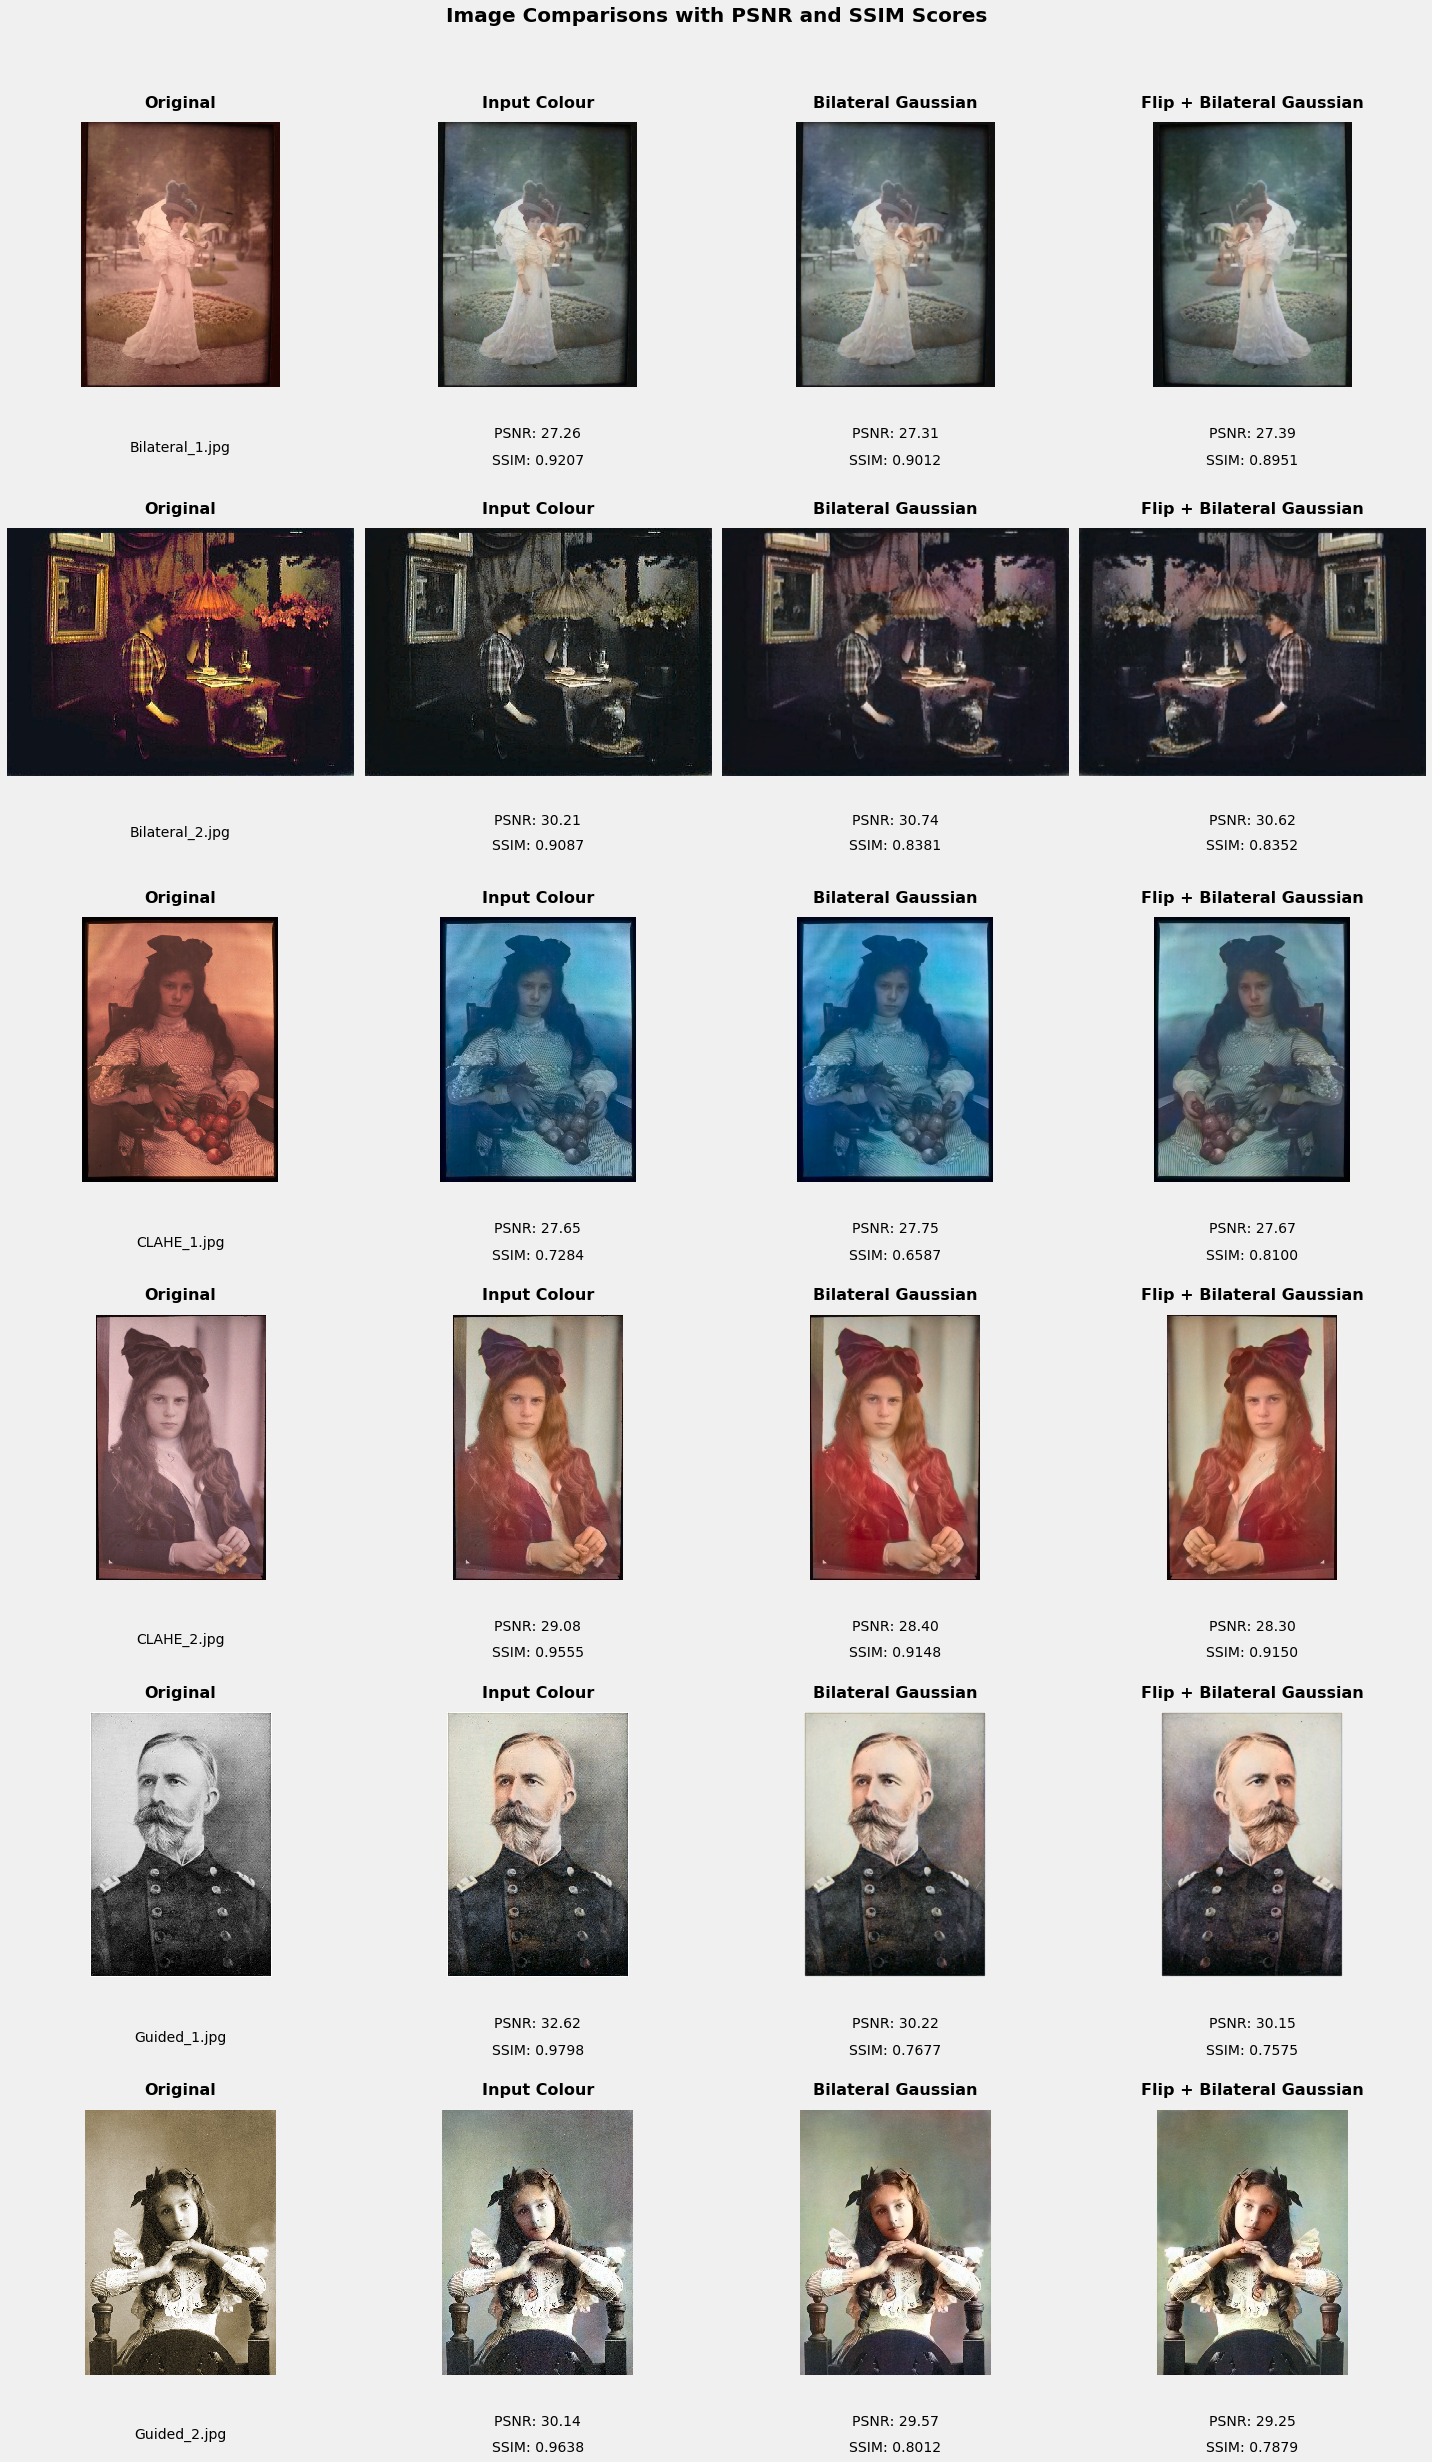

In [41]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Paths to directories and CSV file
original_dir = r'C:\Users\dines\Desktop\sample_images'
input_colour_dir = r'C:\Users\dines\Desktop\sample_color'
bilateral_gaussian_dir = r'C:\Users\dines\Desktop\sample_bilateral_gaussian_color'
flip_bilateral_gaussian_dir = r'C:\Users\dines\Desktop\sample_custom_colour'
output_csv_path = r"C:\Users\dines\Desktop\sample_comparison_results.csv"

# Load the CSV file
scores_df = pd.read_csv(output_csv_path)

# Define the image directories for easy looping with corresponding metrics
image_dirs = {
    "Original": original_dir,
    "Input Colour": input_colour_dir,
    "Bilateral Gaussian": bilateral_gaussian_dir,
    "Flip + Bilateral Gaussian": flip_bilateral_gaussian_dir
}
metrics = [
    ("Input Colour", "PSNR_Input_Colour", "SSIM_Input_Colour"),
    ("Bilateral Gaussian", "PSNR_Bilateral_Gaussian", "SSIM_Bilateral_Gaussian"),
    ("Flip + Bilateral Gaussian", "PSNR_Flip_Bilateral_Gaussian", "SSIM_Flip_Bilateral_Gaussian")
]

# Define the number of columns and rows for the plot
num_images = len(scores_df)
num_dirs = len(image_dirs)
fig, axs = plt.subplots(num_images, num_dirs, figsize=(20, 6 * num_images))  # Increased height for spacing
fig.patch.set_facecolor('#f0f0f0')  # Set a light gray background for the figure

# Loop through each image and display them
for idx, row in scores_df.iterrows():
    image_name = row['Image']  # Use the 'Image' column for image names

    for col_idx, (label, dir_path) in enumerate(image_dirs.items()):
        # Load the image
        img_path = os.path.join(dir_path, image_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying in matplotlib

        # Plot the image
        axs[idx, col_idx].imshow(img)
        axs[idx, col_idx].axis('off')

        # Set title and scores if not original
        if label == "Original":
            title = label
            title_color = 'black'  # Black color for the original title
            
            # Add image name below the original image, slightly above the scores
            axs[idx, col_idx].text(0.5, -0.2, image_name, ha='center', va='top', fontsize=14, color='black', transform=axs[idx, col_idx].transAxes)
        else:
            # Find the PSNR and SSIM for this transformation
            for trans_label, psnr_col, ssim_col in metrics:
                if label == trans_label:
                    psnr = row[psnr_col]
                    ssim = row[ssim_col]
                    title = f"{label}"
                    title_color = 'black'  # Black color for titles

                    # Add scores below the image with black text for labels
                    axs[idx, col_idx].text(0.5, -0.15, f"PSNR: {psnr:.2f}", ha='center', va='top', fontsize=14, color='black', transform=axs[idx, col_idx].transAxes)
                    axs[idx, col_idx].text(0.5, -0.25, f"SSIM: {ssim:.4f}", ha='center', va='top', fontsize=14, color='black', transform=axs[idx, col_idx].transAxes)

        axs[idx, col_idx].set_title(title, fontsize=16, fontweight='bold', color=title_color, pad=15)  # Increased font size for titles

# Adjust layout and display
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for the title
plt.subplots_adjust(hspace=0.5)  # Increase vertical space between rows
plt.suptitle('Image Comparisons with PSNR and SSIM Scores', fontsize=20, fontweight='bold', color='black')  # Increased title font size
plt.show()
